# Introduction to AutoRA
## Basic Tutorial I: Components

**[AutoRA](https://pypi.org/project/autora/)** (**Au**tomated **R**esearch **A**ssistant) is an open-source framework designed to automate various stages of empirical research, including model discovery, experimental design, and data collection.

This notebook is the first of four notebooks within the basic tutorials of ``autora``. We suggest that you go through these notebooks in order as each builds upon the last. However, each notebook is self-contained and so there is no need to *run* the content of the last notebook for your current notebook. We will here provide a link to each notebook, but we will also provide a link at the end of each notebook to navigate you to the next notebook.

[AutoRA Basic Tutorial I: Components](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-I-Components/) <br>
[AutoRA Basic Tutorial II: Loop Constructs](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-II-Loop-Constructs/) <br>
[AutoRA Basic Tutorial III: Workflow Logic](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-III-Workflow-Logic/) <br>
[AutoRA Basic Tutorial IV: Customization](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-IV-Customization/) <br>

These notebooks provide a comprehensive introduction to the capabilities of ``autora``. **It demonstrates the fundamental components of ``autora``, and how they can be combined to facilitate automated (closed-loop) empirical research through synthetic experiments.**

**How to use this notebook** *You can progress through the notebook section by section or directly navigate to specific sections. If you choose the latter, it is recommended to execute all cells in the notebook initially, allowing you to easily rerun the cells in each section later without issues.*

## Installation

The AutoRA ecosystem is a comprehensive collection of packages that together establish a framework for closed-loop empirical research. At the core of this framework is the ``autora`` package, which serves as the parent package and is essential for end users to install.  It provides functionalities for automating workflows in empirical research and includes vetted modules with minimal dependencies.

However, the flexibility of autora extends further with the inclusion of *optional* modules as additional dependencies. Users have the freedom to selectively install these modules based on their specific needs and preferences.

<img src="https://autoresearch.github.io/autora/img/package_overview.png" width="75%" alt="AutoRA Package Structure">

*Optional dependencies enable users to customize their autora environment without worrying about conflicts with other packages within the broader autora ecosystem. To install an optional module, simply use the command ``pip install autora[dependency-name]``, where ``dependency-name`` corresponds to the name of the desired module (see example below).*

To begin, we will install all the relevant optional dependencies. Our main focus will be on two experimentalists: ``experimentalist-falsification`` and ``experimentalist-sampler-novelty``, along with a Bayesian Machine Scientist (BMS) implemented in the ``theorist-bms`` package. It's important to note that installing a module will automatically include the main autora package, as well as any required dependencies for workflow management and running synthetic experiments.


In [ ]:
!pip install -q "autora[experimentalist-falsification]"
!pip install -q "autora[experimentalist-sampler-novelty]"
!pip install -q "autora[experimentalist-sampler-model-disagreement]"
!pip install -q "autora[theorist-bms]"

To make all simulations in this notebook replicable, we will set some seeds.

In [ ]:
import numpy as np
import torch

np.random.seed(42)
torch.manual_seed(42)

# Automated Empirical Research Components

The goal of this section is to set up all ``autora`` components to enable a closed-loop discovery workflow with synthetic data. This involves specifying (1) the experiment runner, (2) a theorist for model discovery, (3) an experimentalist for identifying novel experiment conditions.


*   **Experiment Runner:** The experiment runner collects observations reflecting experimental conditions.
*   **Theorist:** The theorist automates the construction of models from data. These can take many forms, for example linear regression and the bayesian machine scientist.
*   **Experimentalist:** Each experimentalist identifies experimental conditions that yield scientific merit.

<img src="https://github.com/AutoResearch/autora/blob/main/docs/img/modules_overview.png?raw=true" width="75%" alt="AutoRA Components">

Each of these components automates a process of the scientific method that is generally conducted manually. The experiment runner parallels a *research assistant* that collects data from participants. The theorist takes the place of a *computational scientist* that applies modelling techniques to discover how to best describe the data. The experimentalist acts as a *research design expert* to determine the next iteration of experimentation. Each of these steps in the scientific method can be arduous and time consuming to conduct manually, and so ``autora`` allows for the automation of these steps and thus quickens the scientific method by leveraging data-driven techniques.

## Toy Example of the Components
Before jumping into each component in detail, we will present a toy example to provide you with an overview on how these components work together within a closed-loop. After some setup, you will see steps 1-3, which uses the three componens - namely, the EXPERIMENTALIST to propose new conditions, the EXPERIMENT RUNNER to retrieve new observations from those conditions, and the THEORIST to model the new data. We then finish this example by plotting our data and findings.

100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


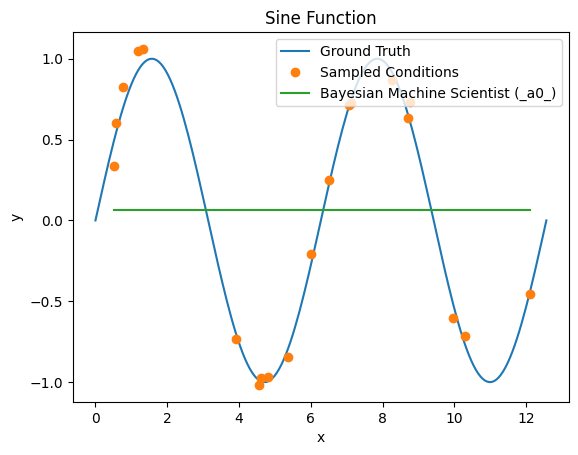

In [ ]:
#Setup: Import modules
import numpy as np
import matplotlib.pyplot as plt
from autora.theorist.bms import BMSRegressor
from autora.experimentalist.sampler.random_sampler import random_sample #Note that this sampler is embedded within the autora-core module and so does not need to be explicitly installed

#Step 0: Defining variables
ground_truth = lambda x: np.sin(x) #Define a ground truth model that we will attempt to recover - here a sine wave
initial_X = np.linspace(0, 4 * np.pi, 200) #Define initial data

#Step 1: EXPERIMENTALIST: Sample using the experimentalist
new_conditions = random_sample(initial_X, n = 20)
new_conditions = np.array(new_conditions).reshape(-1,1) #Turn variable into a 2D array

#Step 2: EXPERIMENT RUNNER: Define and then obtain observations using the experiment runner
run_experiment = lambda x: ground_truth(x) + np.random.normal(0, 0.1, size=x.shape) #Define the runner, which here is simply the ground truth with noise
new_observations = run_experiment(new_conditions) #Obtain observations from the runner for the conditions proposed by the experimentalist
new_observations = new_observations.reshape(-1,1) #Turn variable into a 2D array

#Step 3: THEORIST: Initiate and fit a model using the theorist
theorist_bms = BMSRegressor(epochs=100) #Initiate the BMS theorist
theorist_bms.fit(new_conditions, new_observations) #Fit a model to the data

#Wrap-Up: Plot data and model
sort_index = np.argsort(new_conditions, axis=0)[:,0] #We will first sort our data
new_conditions = new_conditions[sort_index,:]
new_observations = new_observations[sort_index,:]

plt.plot(initial_X, ground_truth(initial_X), label='Ground Truth')
plt.plot(new_conditions, new_observations, 'o', label='Sampled Conditions')
plt.plot(new_conditions, theorist_bms.predict(new_conditions), label=f'Bayesian Machine Scientist ({theorist_bms.repr()})')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine Function')
plt.legend()


***WARNING:*** *Do not stop here! We have now shown you the three components and how they work together. At this point, it may be tempting to start working on your own project, but we urge you to continue through the tutorials. ``autora`` has a lot of embedded functionality that you are going to want to use, and this toy example has stripped those away. So, keep going and see how much ``autora`` has to offer!*

## Experiment Runners

``autora`` provides support for experiment runners, which serve as interfaces for conducting both real-world and synthetic experiments. An experiment runner typically accepts experiment conditions as input (e.g., a 2-dimensional numpy array with columns representing different independent variables) and produces collected observations as output (e.g., a 2-dimensional numpy array with columns representing different dependent variables). These experiment runners can be combined with other ``autora`` components to facilitate closed-loop scientific discovery.

<img src="https://autoresearch.github.io/autora/img/experiment_runner.png" width="75%" alt="AutoRA Components">



### Types

AutoRA offers two types of experiment runners: **real-world experiments** and **synthetic experiments**.

For **real-world experiments**, experiment runners can include interfaces for various scenarios such as web-based experiments for behavioral data collection (e.g., using [Firebase and Prolific](https://autoresearch.github.io/autora/user-guide/experiment-runners/firebase-prolific/)) or experiments involving electrical circuits (e.g., using [Tinkerforge](https://en.wikipedia.org/wiki/Tinkerforge)). These runners often require external components such as databases to store collected observations or servers to host the experiments. You may refer to the respective tutorials for these interfaces on how to set up all required components.

**Synthetic experiments** are conducted on synthetic experiment runners, which are functions that take experimental conditions as input and generate simulated observations as output. These experiments serve multiple purposes, including *testing autora components* before applying them to real-world experiments, *benchmarking methods for automated scientific discovery*, or *conducting computational metascientific experiments*.

In this introductory tutorial, we primarily focus on simple synthetic experiments. For more complex synthetic experiments implementing various scientific models, you can utilize the [autora-synthetic](https://github.com/autoresearch/autora-synthetic/) module.

### Usage

To create a synthetic experiment runner, we begin with **defining a ground truth** from which to generate data. Here, we consider a simple sine function:

$y = f(x) = \sin(x)$

In this case, $x$ corresponds to an *independent* variable (the variable we can manipulate in an experiment), $y$ corresponds to a *dependent* variable (the variable we can observe after conducting the experiment), and $f(x)$ is the *ground-truth function* (or "mechanism") that we seek to uncover via a combination of experimentation and model discovery.

However, we assume that observations are obtained with a measurement error when running the experiment.

$\hat{y} = \hat{f}(x) = f(x) + \epsilon, \quad \epsilon \sim \mathcal{N}(0,0.1)$

where $\epsilon$ is the measurement error sampled from a normal distribution with zero mean and a standard deviation of $0.1$.

The following code block defines the ground truth $f(x)$ and the experiment runner $\hat{f}(x)$ as ``lambda`` functions.

In [ ]:
ground_truth = lambda x: np.sin(x)
run_experiment = lambda x: ground_truth(x) + np.random.normal(0, 0.1, size=x.shape)

Next, we generate a pool of all possible experimental conditions from the domain $[0, 2\pi]$.

In [ ]:
import numpy as np

condition_pool = np.linspace(0, 2 * np.pi, 100)

In order to run a simple synthetic experiment, we can first sample from the pool of possible experiment conditions (without replacement), and then pass these conditions to the synthetic experiment runner:

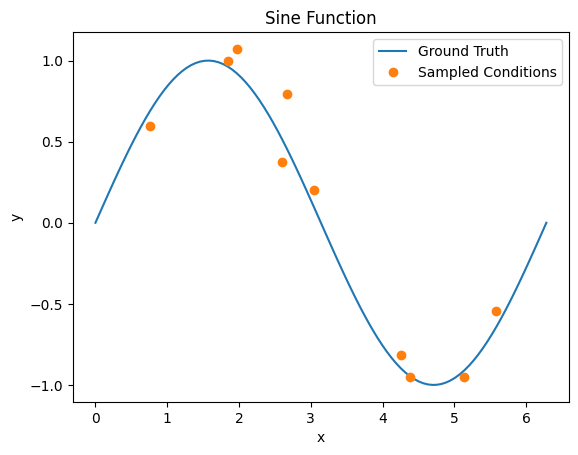

In [ ]:
initial_conditions = np.random.choice(condition_pool, size=10, replace=False)
initial_observations = run_experiment(initial_conditions)

# plot sampled conditions against ground-truth
import matplotlib.pyplot as plt
plt.plot(condition_pool, ground_truth(condition_pool), label='Ground Truth')
plt.plot(initial_conditions, initial_observations, 'o', label='Sampled Conditions')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sine Function')
plt.legend()

Certain theorists and experimentalists may need to have knowledge about the experimental variables, such as the domain from which new experiment conditions are sampled. To provide this information, we can utilize a ``VariableCollection`` object. In the context of our synthetic experiment, we have a single *independent variable* (``IV``) denoted as $x$, and a single *dependent* variable (``DV``) denoted as $y$.

In [ ]:
from autora.variable import DV, IV, ValueType, VariableCollection

# Specify independent variable
iv = IV(
    name="x",                       # name of the independent variable
    value_range=(0, 2 * np.pi),     # specify the domain
    allowed_values=condition_pool,  # alternatively, we can specify the pool of allowed conditions directly
)

# specify dependent variable
dv = DV(
    name="y",                       # name of the dependent variable
    type=ValueType.REAL,            # specify the variable type (some theorists require this to optimize)
)

# Variable collection with ivs and dvs
metadata = VariableCollection(
    independent_variables=[iv],
    dependent_variables=[dv],
)

**Note**: *For expository reasons, we focus in this tutorial on simple synthetic experiments. In general, ``autora`` provides functionality for automating [more complex synthetic experiments](https://github.com/autoresearch/autora-synthetic/), as well as real-world experiments, such as [behavioral data collection via web-based experiments](https://autoresearch.github.io/autora/user-guide/experiment-runners/firebase-prolific/), experiments with electrical circuits via [Tinkerforge](https://en.wikipedia.org/wiki/Tinkerforge), and other automated experimentation platforms.*

## Theorists

The AutoRA framework includes and interfaces with different methods for scientific model discovery. These methods are referred to as *theorists* and are implemented as [sklearn estimators](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html). For general information about theorists, see the respective [AutoRA Documentation](https://autoresearch.github.io/autora/theorist/).

<img src="https://autoresearch.github.io/autora/img/theorist.png" width="75%" alt="Theorist Overview">


Theorists **take as input a set of conditions and observations**. Conditions and observations can typically be passed as *two-dimensional numpy arrays* (with columns corresponding to variables and rows corresponding to different instances of those variables). Theorists then **identify and fit a model** which may be used to predict observations based on experiment conditions.

### Types

There are different types of theorists within the AutoRA framework, each with its own approach to scientific model discovery.

Some theorists focus on *fitting the parameters of a pre-specified model* to the given data (see the scikit learn documentation for a [selection of basic regressors](https://scikit-learn.org/stable/supervised_learning.html)). The model architecture in such cases is typically fixed, while the parameters are adjusted to optimize the model's performance. Linear regression is an example of a parameter-fitting theorist.

Other theorists are concerned with *identifying both the architecture of a model and its parameters*. The model architectures can take various forms, such as equations, causal models, or process models. Implemented as scikit-learn estimators, these theorists aim to discover a model architecture that accurately describes the data. They often operate within a user-defined search space, which specifies the allowable operations or components that can be included in the model. This approach provides more flexibility in exploring different model architectures.

### Usage

In this tutorial, we delve into two types of theorists: (1) a linear regression theorist, which focuses on fitting a linear model, and (2) a Bayesian Machine Scientist (Guimerà et al., 2020, in *Science Advances*), which specializes in identifying and fitting a non-linear equation.

Theorists are commonly instantiated as regressors within the ``sklearn`` library:

In [ ]:
from sklearn import linear_model
from autora.theorist.bms import BMSRegressor

theorist_lr = linear_model.LinearRegression()
theorist_bms = BMSRegressor(epochs=100)

Once instantiated, we can fit the theorist to link experimental conditions with observations. However, before doing so, we should convert both inputs into 2-dimensional numpy arrays.

In [ ]:
# convert data to 2-dimensional numpy array
initial_conditions = initial_conditions.reshape((len(initial_conditions), 1))
initial_observations = initial_observations.reshape((len(initial_observations), 1))
print(f"Size of the initial conditions: {initial_conditions.shape},\nSize of the initial observations: {initial_observations.shape}\n")

# fit theorists
theorist_lr.fit(initial_conditions, initial_observations)
theorist_bms.fit(initial_conditions, initial_observations)

Size of the initial conditions: (10, 1),
Size of the initial observations: (10, 1)



100%|██████████| 100/100 [00:13<00:00,  7.41it/s]


BMSRegressor(epochs=100)

For some theorists, we can inspect the resulting model architecture. For instance, in the BMS theorist, we can call obtain the model formula via ``theorist_bms.repr()``.


In [ ]:
print("Model of BMS theorist: " + theorist_bms.repr())

Model of BMS theorist: sin(X0)


We may now obtain predictions from both theorists for the entire pool of experiment conditions.

In [ ]:
# convert condition pool into 2-dimensional numpy array before generating respective predictions
condition_pool = condition_pool.reshape((len(condition_pool), 1))

# obtain predictions
predicted_observations_lr = theorist_lr.predict(condition_pool)
predicted_observations_bms = theorist_bms.predict(condition_pool)

In the next code segment, we plot the theorists' predictions against the ground truth. For the BMS theorist, we can obtain a latex expression of the model architecture using ``theorist_bms.latex()``.

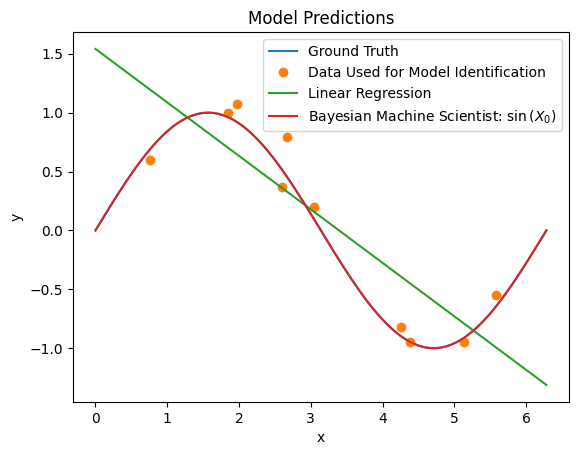

In [ ]:
# obtain latex expression of BMS theorist
bms_model = theorist_bms.latex()

# plot model predictions against ground-truth
import matplotlib.pyplot as plt
plt.plot(condition_pool, ground_truth(condition_pool), label='Ground Truth')
plt.plot(initial_conditions, initial_observations, 'o', label='Data Used for Model Identification')
plt.plot(condition_pool, predicted_observations_lr, label='Linear Regression')
plt.plot(condition_pool, predicted_observations_bms, label='Bayesian Machine Scientist: $' + bms_model + '$')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Model Predictions')
plt.legend()

**Note**: *There are various other types of theorists you can combine with AutoRA as long as they are implemented as ``sklearn`` estimators. This includes [autora modules](theorist/index.md), any [scikit learn estimators](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html), as well as third-party packages, such as [PySR](https://github.com/MilesCranmer/PySR) for symbolic regression.*

## Experimentalists

The primary goal of an experimentalist is to design experiments that yield scientific merit. The AutoRA framework offers various strategies for identifying informative new data points (e.g., by searching for experiment conditions that existing scientific models fail to explain, or by looking for novel conditions altogether).

<img src="https://autoresearch.github.io/autora/img/experimentalist.png" width="75%" alt="Experimentalist Overview">

Experimentalists are implemented as functions that return a set of experiment conditions (e.g., in the form of a 2-dimensional numpy array in which columns correspond to independent variables), which can be subjected to an experiment. To determine these conditions, experimentalists may use information about candidate models obtained from a theorist, experimental conditions that have already been probed, or respective dependent measures. For more detailed information about experimentalists, please refer to the corresponding [AutoRA Documentation](https://autoresearch.github.io/autora/experimentalist/).


### Types

There are generally three types of experimentalist functions: **poolers**, **samplers**, and **pipelines**.

**Poolers** generate a novel set of experimental conditions "from scratch", e.g., by sampling from a grid. They usually require metadata describing independent variables of the experiment (e.g., their range or the set of allowed values).

**Samplers** operate on an existing pool of experimental conditions. They typically require experimental conditions to be represented as a 2-dimensional numpy array in which columns correspond to independent variables and rows to different conditions. They then select experiment conditions from this pool.

**Pipelines** Pipelines connect multiple experimentalists into a unified workflow. This is beneficial when various steps are required to process experiment conditions. For example, apart from identifying novel experimental conditions, experimentalist functions may perform other operations on the set of conditions, such as rearranging the rows of a condition matrix or adding new experiment conditions as columns. Experiment pipelines may begin with a pooler that generates all possible experiment conditions, followed by a sampler that selects a subset of conditions from the pool, and then proceed to additional functions that arrange the selected conditions in a specific order necessary for conducting the experiment.

### Usage: Poolers

Experimentalist poolers are implemented as functions and can be called directly. For instance, the following **grid pooler** generates a grid based on the ``allowed_values`` of all independent variables in the ``metadata`` object that we defined above. We can simply add a list of allowed values to each independent variable. In this case, we only have one variable.

In [ ]:
allowed_values = np.linspace(0, 2 * np.pi, 100)
metadata.independent_variables[0].allowed_values = allowed_values

Now we can pass the grid pooler the list of independent variables from the ``metadata`` object.

In [ ]:
from autora.experimentalist.pooler.grid import grid_pool

new_conditions = grid_pool(ivs = metadata.independent_variables)

The resulting condition pool contains all experiment conditions from the grid:

In [ ]:
# return first 10 conditions
for idx, condition in enumerate(new_conditions):
    print(condition)
    if idx > 9:
        break

(0.6981317007977318,)
(0.7615982190520711,)
(0.8250647373064104,)
(0.8885312555607496,)
(0.9519977738150889,)
(1.0154642920694281,)
(1.0789308103237674,)
(1.1423973285781066,)
(1.2058638468324459,)
(1.269330365086785,)
(1.3327968833411243,)


Alternatively, we may use the **random pooler** to randomly draw experimental conditions from the domains of each independent variable. The random pooler requires as input a list of discrete values from which to sample from. In this case, we can pass it ``metadata.independent_variables[0].allowed_values`` for the independent variable. We can also specify the input argument ``n`` to obtain 10 random samples.

In [ ]:
from autora.experimentalist.pooler.random_pooler import random_pool

# generate random pool of 10 conditions
num_samples = 10
new_conditions = random_pool(metadata.independent_variables[0].allowed_values,
                             n=num_samples)

# print conditons
for idx, condition in enumerate(new_conditions):
    print(condition)

(0.8250647373064104,)
(0.7615982190520711,)
(4.1253236865320515,)
(4.188790204786391,)
(3.236792430971302,)
(3.8714576135146945,)
(3.3637254674799806,)
(6.092785752416569,)
(4.886921905584122,)
(4.950388423838462,)


### Usage: Samplers

An experiment sampler typically requires an existing pool of conditions as input along with additional arguments. For instance, the **[novelty sampler](https://autoresearch.github.io/autora/user-guide/experimentalists/samplers/novelty/)** requires, aside from a pool of conditions, a list of prior conditions. The user may also specify the number of samples ``num_samples`` to select from the pool.

The novelty sampler will then select novel experiment conditions from the pool which are most dissimilar to some reference conditions, such as the ``initial_conditions`` obtained above:

In [ ]:
from autora.experimentalist.sampler.novelty import novelty_sample

new_conditions_novelty = novelty_sample(condition_pool = condition_pool,
                                 reference_conditions = initial_conditions,
                                 num_samples = 2)

print(new_conditions_novelty)

[[0.        ]
 [0.06346652]]


Another example for an experiment sampler is the **[falsification sampler](https://autoresearch.github.io/autora/falsification/docs/sampler/)**. The falsification sampler identifies experiment conditions under which the loss of a candidate model (returned by the theorist) is predicted to be the highest. This loss is approximated with a neural network, which is trained to predict the loss of the candidate model, given some initial experimental conditions, respective initial observations, and the metadata.

The following code segment calls on the falsification sampler to return novel conditions based on the candidate model of the linear regression theorist introduced above. As with the novelty sampler, we seek to select 2 conditions.


In [ ]:
from autora.experimentalist.sampler.falsification import falsification_sample

new_conditions_falsification = falsification_sample(
        condition_pool=condition_pool,
        model=theorist_lr,
        reference_conditions=initial_conditions,
        reference_observations=initial_observations,
        metadata=metadata,
        num_samples=2
    )

print(new_conditions_falsification)

[[0.        ]
 [0.06346652]]


We can plot the selected conditions for both samples relative to the selected samples. Since we don't have observations for those conditions, we plot them as vertical lines.

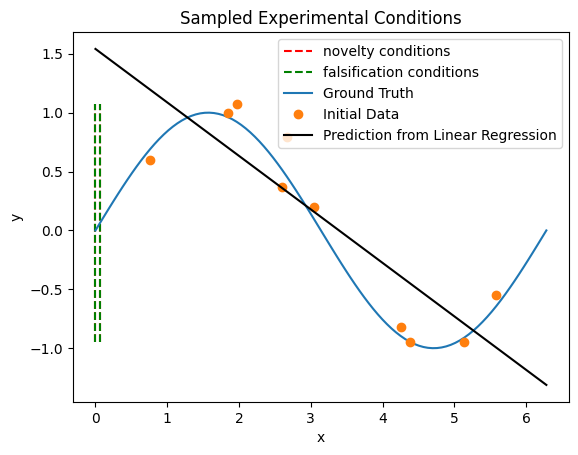

In [ ]:
# plot model predictions against ground-truth
import matplotlib.pyplot as plt

y_min = np.min(initial_observations)
y_max  = np.max(initial_observations)

# plot conditions obtained by novelty sampler
for idx, condition in enumerate(new_conditions_novelty):
    if idx == 0:
        plt.plot([condition[0], condition[0]], [y_min, y_max], '--r', label='novelty conditions')
    else: # we want to omit the label for all other conditions
        plt.plot([condition[0], condition[0]], [y_min, y_max], '--r')

# plot conditions obtained by falsification sampler
for idx, condition in enumerate(new_conditions_falsification):
    if idx == 0:
        plt.plot([condition[0], condition[0]], [y_min, y_max], '--g', label='falsification conditions')
    else: # we want to omit the label for all other conditions
        plt.plot([condition[0], condition[0]], [y_min, y_max], '--g')

plt.plot(condition_pool, ground_truth(condition_pool), '-', label='Ground Truth')
plt.plot(initial_conditions, initial_observations, 'o', label='Initial Data')
plt.plot(condition_pool, predicted_observations_lr, '-k', label='Prediction from Linear Regression')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Sampled Experimental Conditions')
plt.legend()


### Usage: Pipelines

Experimentalists can be connected in a **[pipeline](https://autoresearch.github.io/autora/core/docs/pipeline/Experimentalist%20Pipeline%20Examples/)**, where each element passes its output to the next element, ensuring compatibility between the inputs and outputs. Pipelines offer a flexible and efficient way to orchestrate the workflow involving complex experimentalists (e.g., for processing of experimental conditions) and experiment runners (e.g., for preprocessing of collected observations). They allow for the integration of poolers, samplers, and other design manipulations into a cohesive stream of experimental conditions.

Let's examine the following pipeline example:

<ol>
<li> Generate a grid of all possible experimental conditions.
<li> Filter out conditions where the independent variable falls within the range -1 to 1.
<li> Sample 10 conditions using the novelty sampler.
<li> Select 5 conditions from the sampled set using the falsification sampler.
</ol>

Before creating the pipeline, let's define an additional function that removes experiment conditions falling within the range of -1 to 1, specifically $-1 \leq x \leq 1$. This function will be used in the second step of the pipeline.

In [ ]:
from typing import Iterable

def condition_exclusion(conditions):
    # first we need to make sure that conditions is a 2-dimensional numpy array
    if isinstance(conditions, Iterable):
        conditions = np.array(list(conditions))

    if conditions.ndim == 1:
        conditions = conditions.reshape(-1, 1)

    # now we can sub-select conditions
    conditions_to_keep = conditions[(-1 > conditions) | (conditions > 1)]
    conditions_to_keep = conditions_to_keep.reshape(-1, 1)
    return conditions_to_keep

A pipeline can be defined as a list of functions, such as ``[grid_pool, value_exclusion, novelty_sample, falsification_sample]``. However, to create a pipeline object, we need to specify the required parameters for each element in the pipeline. We can achieve this by providing nested dictionaries containing the additional parameters, as shown in the code block below.

**Note**: *Each element of the pipeline passes its output to the next element as the first argument of the element's function. Thus, we need to make sure that the output of one pipeline element is compatible with the required first input argument for the next element. In our case, the first argument for each pipeline element (except for poolers) is assumed to be a 2-dimensional numpy array specifying a set of experimental conditions.*


In [ ]:
from autora.experimentalist.pipeline import make_pipeline

experimentalist_pipeline = make_pipeline([grid_pool,
                                 condition_exclusion,
                                 novelty_sample,
                                 falsification_sample],
                                params={"grid_pool":
                                            {"ivs": metadata.independent_variables},
                                        "novelty_sample":
                                            {"reference_conditions": initial_conditions,
                                             "num_samples": 10},
                                        "falsification_sample":
                                            {"model": theorist_bms,
                                             "reference_conditions": initial_conditions,
                                             "reference_observations": initial_observations,
                                             "metadata": metadata,
                                             "num_samples": 5}})

In the declaration of the ``params`` parameter, we first specify the name of the pipeline object we seek to parameterize as a dictionary key, e.g., ``"grid_pool"``, and then nest within it, another dictionary with the names of the input arguments as keys (e.g., ``"ivs"``) along with their values (e.g.,  ``metadata.independent_variables``).

Once specified, we can run the pipeline object to obtain novel experimental conditions.

In [ ]:
new_conditions = experimentalist_pipeline.run()

print(new_conditions)

[[1.90399555]
 [3.93492413]
 [5.83891968]
 [5.9023862 ]
 [5.96585272]]


**Hint**: *A common error for running pipelines is that the output of one pipeline element is incompatible with the input of the next pipeline element (e.g., not providing a 2-dimensional numpy array to ``novelty_sample``). In such cases, it can be helpful to "manually" pass the inputs from one element to another element, to check if they are compatible.*

**Note**: *Pipelines may be used for other purposes, such as linking an experiment runner with multiple pre-processing steps.*

# Next Notebook
After defining all the components required for the empirical research process, we can create an automated workflow using basic loop constructs. The next notebook illustrates the use of these loop constructs.

Follow this link for the next notebook tutorial:
[AutoRA Basic Tutorial II: Loop Constructs](https://autoresearch.github.io/autora/tutorials/basic/Tutorial-II-Loop-Constructs/) <br>